In [8]:
import os
import numpy as np
import pandas as pd
from functools import reduce#for merge a list of df
import operator#get a sublist of versions of interest(version_list) from given indeices(version_idx_list)

Connect to Google Drive

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')
#disk_path = os.path.join('drive/My Drive/CNN_Data')

Input the version names for comparison

In [10]:
disk_path = 'F:/server_output/processed/'
#disk_path = 'E:/Diane/Col/research/code/Done/Processed/version_output'
all_version_name = np.sort(os.listdir(disk_path))
print("all_version_name:")
print(all_version_name)

version_list = all_version_name[3:12]#1:7

#version_idx_list = [0,2,4,5]
#version_list = operator.itemgetter(*version_idx)(all_version_name)

print("version_list:")
print(version_list)
#version1='v11.0_processed'
#version2='v13.0_processed'

all_version_name:
['confusion_mat_file_zip' 'v10' 'v11' 'v11.001_processed'
 'v11.002_processed' 'v11.003_processed' 'v11.004_processed'
 'v11.005_processed' 'v11.006_processed' 'v11.007_processed'
 'v11.008_processed' 'v11.009_processed' 'v11.0_processed_0'
 'v13.006_processed' 'v13.0_processed' 'v13.0_processed_0' 'v9.5' 'v9.83'
 'v9.85' 'v9.9']
version_list:
['v11.001_processed' 'v11.002_processed' 'v11.003_processed'
 'v11.004_processed' 'v11.005_processed' 'v11.006_processed'
 'v11.007_processed' 'v11.008_processed' 'v11.009_processed']


### Define some functions



In [11]:
def check_foldername(foldernames,test_string):
    has_test_string = np.zeros((len(foldernames),len(test_string)))
    for f_i,foldername in enumerate(foldernames):
        for s_i,string in enumerate(test_string):
            if string in foldername.lower():
                has_test_string[f_i,s_i] = 1
    #remove foldernames that doesn't contain any element of test_string
    keep_vec = np.sum(has_test_string,1)
    if np.where(keep_vec>0)[0].size < len(foldernames):
        print(f'ignore {len(foldernames)-np.where(keep_vec>0)[0].size} folder')
    foldernames_new = [foldernames[i] for i in np.where(keep_vec>0)[0]]#only keep the folder names with "stem" or "leaf"
    has_test_string_new = np.asarray([has_test_string[i,] for i in np.where(keep_vec>0)[0]])
    return foldernames_new,has_test_string_new

def get_metric_from_line(string):
    '''
    input: "['sensitivity', 62.5), 'precision', 56.18), 'accuracy', 92.32)]\n"
    output: an array of [62.5,56.18,92.32]
    '''
    string2 = string.replace("(","").replace(")","").replace("[","").replace("]","").replace("\n","").replace("'","")
    string_list = string2.split(', ')
    value_vec = np.zeros(int(len(string_list)/2))
    for i in range(0,len(value_vec)):
        value_vec[i] = string_list[1+i*2]
    return value_vec

def clean_folder_name(all_folders_name,has_stem_leaf,stem_leaf_list):
    '''
    input: ['Alclat2_stem.DONEGOOD.HANNAH.9.26', 'casarb2.2_stem.HANNAHDONEGOD.11.4', 'casarb5_stem.DONEGOOD.HANNAH.11.7'...]
    output: ['Alclat2_stem', 'casarb2.2_stem', 'casarb5_stem',...]
    '''
    all_folders_name_short=all_folders_name.copy()
    for i, foldername in enumerate(all_folders_name):
        terminate_word = stem_leaf_list[int(np.where(has_stem_leaf[i]>0)[0])]#stem or leaf
        stop_index = foldername.lower().find(terminate_word)
        all_folders_name_short[i] = foldername[:(stop_index+len(terminate_word))]
    return all_folders_name_short

def color_val(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, green for positive, black otherwise.
    """
    
    if val < -0.1:
        color = 'red'
    elif val > 0.1 :
        color = 'green'
    else:
         color = 'white'
    return 'color: %s' % color

def get_arg_table_for_each_stage():
    column_names = np.arange(0.001, 0.009, 0.001)#0.001~0.008, w/ increment=0.001
    num_col = len(column_names)
    row_names = ['3_main_detect','1_foreground_seg','2_poor_qual','4_rm_big_emb','5_rolling_window','6_sep_weak_strong_emb','7_rm_small_emb']
    #the number at front represents the order of the stages in the algo.
    num_row = len(row_names)
    #print(num_row,num_col)
    arg_df = pd.DataFrame(np.zeros((num_row,num_col)), columns=column_names, index=row_names, dtype=np.int)
    #arg_df.iloc[:, (arg_df.columns==0)] = 1 #version XX.0 runs all stages
    arg_df.loc['3_main_detect', :] = 1 #every version runs main_detect stage

    #.001 version doesn't run any other stage than main_detect stage
    #.008 is a bit unusual, 0.002-0.007 add one stage at a time, ignoring main_detect
    row_ignore_main = row_names.copy()
    row_ignore_main.remove('3_main_detect')
    
    i = 0
    for col_i in np.arange(0.002,0.008,0.001):
        #print(col_i)
        arg_df.loc[:,col_i] = arg_df.loc[:,col_i-0.001] # the same as last version
        arg_df.loc[row_ignore_main[i],col_i] = 1 # add another stage to current version
        i += 1


    #.008 only doesn't run rolling window
    arg_df.loc[:,0.008]=1
    arg_df.loc['5_rolling_window',0.008]=0
    
    #.009 doesn't run 4_rm_big_emb and 5_rolling_window 
    arg_df.loc[:,0.009]=arg_df.loc[:,0.008]
    arg_df.loc['4_rm_big_emb',0.009]=0
    
    ##re-order the columns, move version .0 to the last one, because it runs "all" stages
    #arg_df = arg_df[column_names[1:].tolist()+column_names[0:1].tolist()]
    
    return(arg_df)

def subset_metric_df(metric_df_join,version=None,level=None,metric=None):
    if version==None and level!=None and metric!=None:
        return metric_df_join.iloc[:,  (metric_df_join.columns.get_level_values(1)==level)& (metric_df_join.columns.get_level_values(2)==metric)]
    else:
        sys.exit("Haven't write subset_metric_df for this combination of arguments")
def get_metric_avg_df(list_df , new_colnames, drop_level_list):
    new_list_df = []
    i = 0
    for one_df in list_df:
        one_df_new = one_df.iloc[-1,:]
        for drop_col_level in drop_level_list:
            one_df_new = one_df_new.droplevel(drop_col_level)#remove some column levels
        one_df_new = one_df_new.rename(new_colnames[i])
        new_list_df.append(one_df_new)
        i += 1
    new_df = reduce(lambda x, y: pd.merge(x, y, how='inner', left_index=True, right_index=True), new_list_df)#inner merge new_list_df
    return new_df

The main function for one version's summary result

In [12]:
def one_version_pd(disk_path,version_name):
    '''
    input:
        disk path: home directory for each version's result
        version_name: disk_path/version_name will be the directory for the version in interest
    
    outputs:
        metric_df:　shape = number of folders in this version x 9
            9 cols = 3 levels ('img level','pixel level','cluster level') x 3 metric in each level ('sensitivity','precision','accuracy')
        img_cm_df: 2 by 2 img level confusion matrix for every folder in this version 
    '''
    print(f'version {version_name} ...')
    version_dir = os.path.join(disk_path,version_name)
    all_folders_name = sorted(os.listdir(version_dir))
    #print(f'{all_folders_name}')
    #only keep the folder names with "stem" or "leaf" (i.e. ignore folders like "output")
    stem_leaf_list = ["stem","leaf"]
    all_folders_name,has_stem_leaf = check_foldername(all_folders_name,stem_leaf_list)
    #print(f'{has_stem_leaf}')#len(all_folders_name) x 2: each entry is {0 or 1}. 1st col "stem", 2nd col "leaf"
    all_folders_name_short = clean_folder_name(all_folders_name,has_stem_leaf,stem_leaf_list)
    #print(f'{all_folders_name_short}')

    all_folders_dir = [os.path.join(version_dir,folder) for folder in all_folders_name]
    all_folders_dir_processed = [os.path.join(folder_dir, os.listdir(folder_dir)[0]) for folder_dir in all_folders_dir]
    #print(f'{all_folders_dir_processed}')
    all_line_header = ['img level metric','pixel level metric','cluster level metric']
    all_line_header_num = len(all_line_header)
    all_line_header_short = [b.replace(" metric","") for b in all_line_header]
    metric_name_list = ['sensitivity','precision','accuracy']
    metric_num = len(metric_name_list)
    folder_metric_arr = np.zeros((len(all_folders_name),len(all_line_header*metric_num)))

    cm_colname = ['Predict 0', 'Predict 1']
    cm_rowname = ['True 0', 'True 1']
    cm_row = len(cm_rowname)# number of rows in a confusion matrix
    cm_col = len(cm_colname)
    #img_cm = ["" for x in range(len(all_folders_name)*cm_row)]#list
    img_cm = np.zeros((len(all_folders_name)*cm_row,cm_col))
    for p_i, processed_path in enumerate(all_folders_dir_processed):
        folder_name = all_folders_name[p_i]
        #print(f'processing {folder_name} ...')
        print(f'{all_folders_name_short[p_i]}')
        con_mat_path = os.path.join(processed_path,'confusion_mat_file.txt')
        if os.path.exists(con_mat_path):#check if confusion_mat_file.txt exists
            with open (con_mat_path) as file:
                datafile=file.readlines()
                for l_i,line in enumerate(datafile):
                    for lh_i,line_header in enumerate(all_line_header):
                        if line_header in line:
                            st = lh_i*metric_num
                            end = st+metric_num
                            folder_metric_arr[p_i,st:end] = get_metric_from_line(datafile[l_i+1])#"l_i+1":next line of 'img level metric'
                            if line_header == 'img level metric':
                                st = p_i*cm_row
                                for cm_i in range(cm_row):
                                    line_string_list = datafile[l_i+4+cm_i].replace("\n","").split()
                                    p0 = float(line_string_list[2])#predict 0
                                    p1 = float(line_string_list[-1])
                                    img_cm[st+cm_i,:] = [p0,p1]
        else:#if confusion_mat_file.txt doesn't exist, filled up with NaN
            folder_metric_arr[p_i,:] = np.nan
            st = p_i*cm_row
            for cm_i in range(cm_row):
                img_cm[st+cm_i,:] = [np.nan,np.nan]
    
    version_name_short = version_name.replace("_processed","") 
    #add headers
    column_names_arr = [([version_name_short]*all_line_header_num*metric_num), np.repeat(all_line_header,3).tolist(),(metric_name_list*3)]
    col_tuples = list(zip(*column_names_arr))
    column_names = pd.MultiIndex.from_tuples(col_tuples, names=['version','level', 'metric'])
    metric_df = pd.DataFrame(folder_metric_arr, columns=column_names, index=all_folders_name_short)

    #img_cm = img_cm.astype(int)#convert from float to int
    #add headers
    column_names_arr_img = [([version_name_short]*cm_col),cm_colname]#+' img level con. matrix'
    col_tuples_img = list(zip(*column_names_arr_img))
    column_names_img = pd.MultiIndex.from_tuples(col_tuples_img, names=['version/level', 'predic/label'])
    row_names_arr_img = [np.repeat(all_folders_name_short,cm_row).tolist(),cm_rowname*len(all_folders_name_short)]
    row_tuples_img = list(zip(*row_names_arr_img))
    row_names_img = pd.MultiIndex.from_tuples(row_tuples_img)
    img_cm_df = pd.DataFrame(img_cm, columns=column_names_img, index=row_names_img)
    
    #ignore NaN, due to confusion_mat_file.txt not existing
    metric_df = metric_df.dropna()
    img_cm_df = img_cm_df.dropna()
    return metric_df,img_cm_df

## Compare two versions metric results

In [13]:
metric_df_list = []
img_cm_list =[]
for i in range(len(version_list)):
    metric_df_i,img_cm_i = one_version_pd(disk_path,version_list[i])
    metric_df_list.append(metric_df_i)
    img_cm_list.append(img_cm_i)

version v11.001_processed ...
casarb2.2_stem
casarb5_stem
inglau3_stem
inglau4_stem
inglau5_stem
version v11.002_processed ...
casarb2.2_stem
casarb5_stem
inglau3_stem
inglau4_stem
inglau5_stem
version v11.003_processed ...
casarb2.2_stem
casarb5_stem
inglau3_stem
inglau4_stem
inglau5_stem
version v11.004_processed ...
casarb2.2_stem
casarb5_stem
inglau3_stem
inglau4_stem
inglau5_stem
version v11.005_processed ...
casarb2.2_stem
casarb5_stem
inglau3_stem
inglau4_stem
inglau5_stem
version v11.006_processed ...
casarb2.2_stem
casarb5_stem
inglau3_stem
inglau4_stem
inglau5_stem
version v11.007_processed ...
casarb2.2_stem
casarb5_stem
inglau3_stem
inglau4_stem
inglau5_stem
version v11.008_processed ...
casarb2.2_stem
casarb5_stem
inglau3_stem
inglau4_stem
inglau5_stem
version v11.009_processed ...
casarb2.2_stem
casarb5_stem
inglau3_stem
inglau4_stem
inglau5_stem


#### Print out result of each version


In [14]:
for i in range(len(version_list)):
    display(metric_df_list[i])

version                 v11.001                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            100.0      3.26     4.91              85.08   
casarb5_stem              100.0      3.00     3.91              88.01   
inglau3_stem              100.0      2.84     2.84              86.32   
inglau4_stem              100.0      1.36     4.13              91.48   
inglau5_stem              100.0      0.98     1.26              83.98   

version                                                                    
level                             cluster level metric                     
metric         precision accuracy          sensitivity precision accuracy  
casarb2.2_stem      3.72    99.15               100.00      0.90     1.23  
casarb5_stem        0.35    98.71                97.14      0.42     0.50  
inglau3_stem        0.46    97.97                91.67      0.42     0.42  
inglau4_stem        0.33    99.17               100.00      0.23     0.50  
inglau5_stem        0.22    99.11               100.00      0.08     0.10

version                 v11.002                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            97.78      3.70    18.30              76.92   
casarb5_stem             100.00      3.31    13.26              88.00   
inglau3_stem             100.00      3.95    30.84              85.54   
inglau4_stem             100.00      1.82    28.43              91.48   
inglau5_stem              85.71      1.60    48.32              81.03   

version                                                                    
level                             cluster level metric                     
metric         precision accuracy          sensitivity precision accuracy  
casarb2.2_stem      8.66    99.68                96.88      1.95     8.09  
casarb5_stem        1.93    99.77                98.57      1.82     5.35  
inglau3_stem        7.08    99.88                91.67      1.89    13.57  
inglau4_stem        2.04    99.87               100.00      1.25    13.69  
inglau5_stem        3.75    99.95                77.78      1.00    33.24

version                 v11.003                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            97.78      3.70    18.38              76.92   
casarb5_stem             100.00      3.31    13.33              88.00   
inglau3_stem             100.00      3.95    30.84              85.54   
inglau4_stem             100.00      1.82    28.43              91.48   
inglau5_stem              85.71      1.60    48.46              81.03   

version                                                                    
level                             cluster level metric                     
metric         precision accuracy          sensitivity precision accuracy  
casarb2.2_stem      8.87    99.69                96.88      1.95     8.12  
casarb5_stem        1.97    99.77                98.57      1.82     5.38  
inglau3_stem        7.08    99.88                91.67      1.89    13.57  
inglau4_stem        2.04    99.87               100.00      1.25    13.69  
inglau5_stem        4.29    99.96                77.78      1.00    33.33

version                 v11.004                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            97.78      3.70    18.38              76.92   
casarb5_stem              97.56      3.30    14.93              85.69   
inglau3_stem             100.00      3.96    31.02              85.54   
inglau4_stem             100.00      1.82    28.61              91.48   
inglau5_stem              85.71      1.61    48.74              81.03   

version                                                                    
level                             cluster level metric                     
metric         precision accuracy          sensitivity precision accuracy  
casarb2.2_stem      8.87    99.69                96.88      1.95     8.12  
casarb5_stem        2.63    99.83                94.29      1.76     5.93  
inglau3_stem        7.49    99.88                91.67      1.90    13.67  
inglau4_stem        2.22    99.88               100.00      1.25    13.78  
inglau5_stem        5.39    99.97                77.78      1.00    33.52

version                 v11.005                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            97.78      5.37    44.73              59.12   
casarb5_stem              95.12      3.78    27.97              72.17   
inglau3_stem             100.00      5.57    51.73              82.61   
inglau4_stem             100.00      2.99    57.08              75.39   
inglau5_stem              85.71      2.75    70.25              80.99   

version                                                                    
level                             cluster level metric                     
metric         precision accuracy          sensitivity precision accuracy  
casarb2.2_stem     14.43    99.85                95.31      2.48    21.14  
casarb5_stem        2.92    99.87                92.86      1.84    10.60  
inglau3_stem       10.34    99.92                91.67      2.25    23.67  
inglau4_stem        3.42    99.94               100.00      1.58    28.39  
inglau5_stem        6.71    99.97                77.78      1.31    48.74

version                 v11.006                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            93.33     46.15    96.30              57.36   
casarb5_stem              85.37     20.96    90.00              69.37   
inglau3_stem              96.88     37.80    95.38              80.33   
inglau4_stem             100.00     13.57    91.56              71.94   
inglau5_stem              71.43     14.71    95.67              79.75   

version                                                                    
level                             cluster level metric                     
metric         precision accuracy          sensitivity precision accuracy  
casarb2.2_stem     29.73    99.93                78.12     38.17    93.47  
casarb5_stem        9.11    99.96                75.71     23.35    86.84  
inglau3_stem       33.19    99.98                75.00     37.50    93.74  
inglau4_stem        9.03    99.98                83.87     13.20    87.37  
inglau5_stem       14.72    99.99                66.67     12.77    93.97

version                 v11.007                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            93.33     47.19    96.44              57.36   
casarb5_stem              82.93     22.67    91.09              69.27   
inglau3_stem              96.88     41.33    96.00              80.33   
inglau4_stem              94.29     14.86    92.77              71.66   
inglau5_stem              71.43     17.86    96.51              79.75   

version                                                                    
level                             cluster level metric                     
metric         precision accuracy          sensitivity precision accuracy  
casarb2.2_stem     29.74    99.93                78.12     38.76    93.61  
casarb5_stem        9.16    99.96                74.29     24.76    87.87  
inglau3_stem       33.37    99.98                75.00     40.45    94.35  
inglau4_stem        9.10    99.98                80.65     13.97    88.52  
inglau5_stem       14.95    99.99                66.67     15.00    94.92

version                 v11.008                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            97.78     12.61    78.21              75.43   
casarb5_stem              87.80     15.79    85.72              82.95   
inglau3_stem              96.88     16.67    86.13              83.33   
inglau4_stem              94.29      7.10    83.57              89.66   
inglau5_stem              71.43     12.50    94.83              79.80   

version                                                                    
level                             cluster level metric                     
metric         precision accuracy          sensitivity precision accuracy  
casarb2.2_stem     15.90    99.84                92.19     13.98    75.15  
casarb5_stem        7.03    99.94                78.57     16.77    80.67  
inglau3_stem       20.60    99.96                75.00     15.13    81.99  
inglau4_stem        4.30    99.94                87.10      7.81    77.56  
inglau5_stem       12.67    99.99                66.67     10.71    92.77

version                 v11.009                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            97.78     12.61    78.21              75.43   
casarb5_stem              90.24     14.68    84.13              84.85   
inglau3_stem              96.88     16.49    85.96              83.33   
inglau4_stem              94.29      7.04    83.42              89.66   
inglau5_stem              71.43     12.20    94.69              79.80   

version                                                                    
level                             cluster level metric                     
metric         precision accuracy          sensitivity precision accuracy  
casarb2.2_stem     15.90    99.84                92.19     13.98    75.15  
casarb5_stem        3.81    99.89                81.43     15.53    78.52  
inglau3_stem       18.05    99.96                75.00     14.94    81.75  
inglau4_stem        3.88    99.93                87.10      7.77    77.42  
inglau5_stem       10.72    99.98                66.67     10.53    92.63

In [15]:
#metric_df_join = pd.concat(metric_df_list,axis=1)#default is 'outer'. 
#So, if the number of folders in different versions are different, some elements might be NaN

#'inner' merge: only keep intersection of folders
metric_df_join = reduce(lambda x, y: pd.merge(x, y, how='inner', left_index=True, right_index=True), metric_df_list)
metric_df_join.loc["Average"] = metric_df_join.mean(axis = 0)
display(metric_df_join)

version                 v11.001                                        \
level          img level metric                    pixel level metric   
metric              sensitivity precision accuracy        sensitivity   
casarb2.2_stem            100.0     3.260     4.91             85.080   
casarb5_stem              100.0     3.000     3.91             88.010   
inglau3_stem              100.0     2.840     2.84             86.320   
inglau4_stem              100.0     1.360     4.13             91.480   
inglau5_stem              100.0     0.980     1.26             83.980   
Average                   100.0     2.288     3.41             86.974   

version                                                                    \
level                             cluster level metric                      
metric         precision accuracy          sensitivity precision accuracy   
casarb2.2_stem     3.720   99.150              100.000      0.90     1.23   
casarb5_stem       0.350   98.710               97.140      0.42     0.50   
inglau3_stem       0.460   97.970               91.670      0.42     0.42   
inglau4_stem       0.330   99.170              100.000      0.23     0.50   
inglau5_stem       0.220   99.110              100.000      0.08     0.10   
Average            1.016   98.822               97.762      0.41     0.55   

version                 v11.002  ...              v11.008          v11.009  \
level          img level metric  ... cluster level metric img level metric   
metric              sensitivity  ...             accuracy      sensitivity   
casarb2.2_stem           97.780  ...               75.150           97.780   
casarb5_stem            100.000  ...               80.670           90.240   
inglau3_stem            100.000  ...               81.990           96.880   
inglau4_stem            100.000  ...               77.560           94.290   
inglau5_stem             85.710  ...               92.770           71.430   
Average                  96.698  ...               81.628           90.124   

version                                                                  \
level                             pixel level metric                      
metric         precision accuracy        sensitivity precision accuracy   
casarb2.2_stem    12.610   78.210             75.430    15.900    99.84   
casarb5_stem      14.680   84.130             84.850     3.810    99.89   
inglau3_stem      16.490   85.960             83.330    18.050    99.96   
inglau4_stem       7.040   83.420             89.660     3.880    99.93   
inglau5_stem      12.200   94.690             79.800    10.720    99.98   
Average           12.604   85.282             82.614    10.472    99.92   

version                                                 
level          cluster level metric                     
metric                  sensitivity precision accuracy  
casarb2.2_stem               92.190     13.98   75.150  
casarb5_stem                 81.430     15.53   78.520  
inglau3_stem                 75.000     14.94   81.750  
inglau4_stem                 87.100      7.77   77.420  
inglau5_stem                 66.670     10.53   92.630  
Average                      80.478     12.55   81.094  

[6 rows x 81 columns]

### Print out img level confusion matrix

In [16]:
img_cm_join = reduce(lambda x, y: pd.merge(x, y, how='inner', left_index=True, right_index=True), img_cm_list)
img_cm_join

version/level           v11.001             v11.002             v11.003  \
predic/label          Predict 0 Predict 1 Predict 0 Predict 1 Predict 0   
casarb2.2_stem True 0      24.0    1335.0     213.0    1146.0     214.0   
               True 1       0.0      45.0       1.0      44.0       1.0   
casarb5_stem   True 0      13.0    1326.0     142.0    1197.0     143.0   
               True 1       0.0      41.0       0.0      41.0       0.0   
inglau3_stem   True 0       0.0    1093.0     315.0     778.0     315.0   
               True 1       0.0      32.0       0.0      32.0       0.0   
inglau4_stem   True 0      74.0    2533.0     716.0    1891.0     716.0   
               True 1       0.0      35.0       0.0      35.0       0.0   
inglau5_stem   True 0       2.0     707.0     340.0     369.0     341.0   
               True 1       0.0       7.0       1.0       6.0       1.0   

version/level                     v11.004             v11.005            \
predic/label          Predict 1 Predict 0 Predict 1 Predict 0 Predict 1   
casarb2.2_stem True 0    1145.0     214.0    1145.0     584.0     775.0   
               True 1      44.0       1.0      44.0       1.0      44.0   
casarb5_stem   True 0    1196.0     166.0    1173.0     347.0     992.0   
               True 1      41.0       1.0      40.0       2.0      39.0   
inglau3_stem   True 0     778.0     317.0     776.0     550.0     543.0   
               True 1      32.0       0.0      32.0       0.0      32.0   
inglau4_stem   True 0    1891.0     721.0    1886.0    1473.0    1134.0   
               True 1      35.0       0.0      35.0       0.0      35.0   
inglau5_stem   True 0     368.0     343.0     366.0     497.0     212.0   
               True 1       6.0       1.0       6.0       1.0       6.0   

version/level           v11.006             v11.007             v11.008  \
predic/label          Predict 0 Predict 1 Predict 0 Predict 1 Predict 0   
casarb2.2_stem True 0    1310.0      49.0    1312.0      47.0    1054.0   
               True 1       3.0      42.0       3.0      42.0       1.0   
casarb5_stem   True 0    1207.0     132.0    1223.0     116.0    1147.0   
               True 1       6.0      35.0       7.0      34.0       5.0   
inglau3_stem   True 0    1042.0      51.0    1049.0      44.0     938.0   
               True 1       1.0      31.0       1.0      31.0       1.0   
inglau4_stem   True 0    2384.0     223.0    2418.0     189.0    2175.0   
               True 1       0.0      35.0       2.0      33.0       2.0   
inglau5_stem   True 0     680.0      29.0     686.0      23.0     674.0   
               True 1       2.0       5.0       2.0       5.0       2.0   

version/level                     v11.009            
predic/label          Predict 1 Predict 0 Predict 1  
casarb2.2_stem True 0     305.0    1054.0     305.0  
               True 1      44.0       1.0      44.0  
casarb5_stem   True 0     192.0    1124.0     215.0  
               True 1      36.0       4.0      37.0  
inglau3_stem   True 0     155.0     936.0     157.0  
               True 1      31.0       1.0      31.0  
inglau4_stem   True 0     432.0    2171.0     436.0  
               True 1      33.0       2.0      33.0  
inglau5_stem   True 0      35.0     673.0      36.0  
               True 1       5.0       2.0       5.0

### Image level metrics averaged over experiments(folders) 

version,v11.001,v11.002,v11.003,v11.004,v11.005,v11.006,v11.007,v11.008,v11.009
level,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric
metric,sensitivity,sensitivity,sensitivity,sensitivity,sensitivity,sensitivity,sensitivity,sensitivity,sensitivity
casarb2.2_stem,100.0,97.780,97.780,97.78,97.780,93.330,93.330,97.780,97.780
casarb5_stem,100.0,100.000,100.000,97.56,95.120,85.370,82.930,87.800,90.240
inglau3_stem,100.0,100.000,100.000,100.00,100.000,96.880,96.880,96.880,96.880
inglau4_stem,100.0,100.000,100.000,100.00,100.000,100.000,94.290,94.290,94.290
inglau5_stem,100.0,85.710,85.710,85.71,85.710,71.430,71.430,71.430,71.430
Average,100.0,96.698,96.698,96.21,95.722,89.402,87.772,89.636,90.124


version,v11.001,v11.002,v11.003,v11.004,v11.005,v11.006,v11.007,v11.008,v11.009
level,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric
metric,precision,precision,precision,precision,precision,precision,precision,precision,precision
casarb2.2_stem,3.260,3.700,3.700,3.700,5.370,46.150,47.190,12.610,12.610
casarb5_stem,3.000,3.310,3.310,3.300,3.780,20.960,22.670,15.790,14.680
inglau3_stem,2.840,3.950,3.950,3.960,5.570,37.800,41.330,16.670,16.490
inglau4_stem,1.360,1.820,1.820,1.820,2.990,13.570,14.860,7.100,7.040
inglau5_stem,0.980,1.600,1.600,1.610,2.750,14.710,17.860,12.500,12.200
Average,2.288,2.876,2.876,2.878,4.092,26.638,28.782,12.934,12.604


version,v11.001,v11.002,v11.003,v11.004,v11.005,v11.006,v11.007,v11.008,v11.009
level,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric,img level metric
metric,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy
casarb2.2_stem,4.91,18.30,18.380,18.380,44.730,96.300,96.440,78.210,78.210
casarb5_stem,3.91,13.26,13.330,14.930,27.970,90.000,91.090,85.720,84.130
inglau3_stem,2.84,30.84,30.840,31.020,51.730,95.380,96.000,86.130,85.960
inglau4_stem,4.13,28.43,28.430,28.610,57.080,91.560,92.770,83.570,83.420
inglau5_stem,1.26,48.32,48.460,48.740,70.250,95.670,96.510,94.830,94.690
Average,3.41,27.83,27.888,28.336,50.352,93.782,94.562,85.692,85.282


,avg sensitivity,avg precision,avg accuracy
version,,,
v11.001,100.000,2.288,3.410
v11.002,96.698,2.876,27.830
v11.003,96.698,2.876,27.888
v11.004,96.210,2.878,28.336
v11.005,95.722,4.092,50.352
v11.006,89.402,26.638,93.782
v11.007,87.772,28.782,94.562
v11.008,89.636,12.934,85.692
v11.009,90.124,12.604,85.282


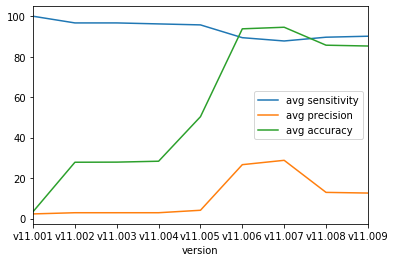

In [21]:
avg_colnames = ['avg sensitivity','avg precision','avg accuracy']

img_df_list = []
metric_name_list = ['sensitivity','precision','accuracy']
for metric_name in metric_name_list:
    img_df_metric = subset_metric_df(metric_df_join,level='img level metric',metric=metric_name)
    display(img_df_metric)
    img_df_list.append(img_df_metric)
    
img_metric_avg = get_metric_avg_df(img_df_list, new_colnames=avg_colnames, drop_level_list=['metric','level'])
display(img_metric_avg)
display(img_metric_avg.plot.line())

### What does each version mean? (depends on the third digit after decimal)

the number in front of each stage represents the **order** of the stages in the algo.
'3_main_detect' is moved to the top (not following the order of the stages in the algo), to make it looks like an upper triangular matrix

In [18]:
arg_df = get_arg_table_for_each_stage()
display(arg_df.style.applymap(color_val))

,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009
3_main_detect,1,1,1,1,1,1,1,1,1
1_foreground_seg,0,1,1,1,1,1,1,1,1
2_poor_qual,0,0,1,1,1,1,1,1,1
4_rm_big_emb,0,0,0,1,1,1,1,1,0
5_rolling_window,0,0,0,0,1,1,1,0,0
6_sep_weak_strong_emb,0,0,0,0,0,1,1,1,1
7_rm_small_emb,0,0,0,0,0,0,1,1,1


### Cluster level metrics averaged over experiments(folders) 

,avg sensitivity,avg precision,avg accuracy
version,,,
v11.001,97.762,0.410,0.550
v11.002,92.980,1.582,14.788
v11.003,92.980,1.582,14.818
v11.004,92.124,1.572,15.004
v11.005,91.524,1.892,26.508
v11.006,75.874,24.998,91.078
v11.007,74.946,26.588,91.854
v11.008,79.906,12.880,81.628
v11.009,80.478,12.550,81.094


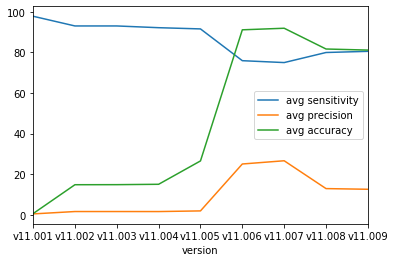

In [19]:
cl_df_list = []
metric_name_list = ['sensitivity','precision','accuracy']
for metric_name in metric_name_list:
    cl_df_list.append(subset_metric_df(metric_df_join,level='cluster level metric',metric=metric_name))
    
cl_metric_avg = get_metric_avg_df(cl_df_list, new_colnames=avg_colnames, drop_level_list=['metric','level'])
display(cl_metric_avg)
display(cl_metric_avg.plot.line())

### Pixel level metrics averaged over experiments(folders) 

,avg sensitivity,avg precision,avg accuracy
version,,,
v11.001,86.974,1.016,98.822
v11.002,84.594,4.692,99.830
v11.003,84.594,4.850,99.834
v11.004,84.132,5.320,99.850
v11.005,74.056,7.564,99.910
v11.006,71.750,19.156,99.968
v11.007,71.674,19.264,99.968
v11.008,82.234,12.100,99.934
v11.009,82.614,10.472,99.920


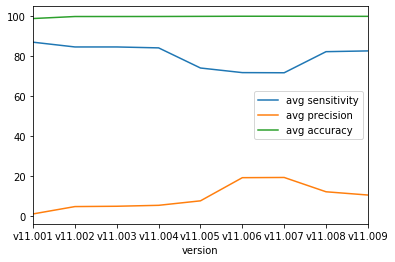

In [20]:
px_df_list = []
metric_name_list = ['sensitivity','precision','accuracy']
for metric_name in metric_name_list:
    px_df_list.append(subset_metric_df(metric_df_join,level='pixel level metric',metric=metric_name))
    
px_metric_avg = get_metric_avg_df(px_df_list, new_colnames=avg_colnames, drop_level_list=['metric','level'])
display(px_metric_avg)
display(px_metric_avg.plot.line())

v11.006(sep_weak_strong_emb set to True) removes "a lot of" images with weak predicted embolism while might also scarifice some images with true weak embolism. So the sensitivity drops (FN increases) while accuracy increases (FP drops).

However, since the changes are in "weak" embolism, the effect in pixel level isn't that obvious compared to that in image or cluster level. Ex: c5_stem (FN: img index: 133, 189, 1089, 1206, 1207 are all really small ones)

On the other hand, looking at "pixel level" results, sensitivity drops a lot at v11.005(rolling window set to True). Because, it sometimes accidentally breaks the embolism event into different parts. Ex: In4_stem: 97,118, 153, 157, 173 (might have only one cc, but should extend longer), 175(connect and missing at the bottom),185(missing at the bottom),188,189,194, 232(missing a bit at the bottom), 854(missing a bit at top) → but if no rolling window(v11.008, things look good before 200, but has bubbles)

Average accuracy in pixel level is always close to 100 because MOST of the pixels are NOT embolism. In fact, the number of true embolized pixel vs the number of not embolized pixel is very IMBALANCED)

#### PR-AUC
AUC:more neutral, doesn’t depend on class size(our class sizes are very imbalanced. sensitivity and precision might depend on class size)
PR instead of ROC: Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

reference: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
